# Starbucks Project

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.


# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

from sklearn.preprocessing import MultiLabelBinarizer

import matplotlib.pyplot as plt
import seaborn as sb



# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data Cleaning 

### 1. Portfolio Data

In [2]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [3]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [4]:
 def clean_portfolio(df) :
        
    # copy portfolio for cleaning .

    cleaned_portfolio = df.copy()
    
    # rename column 'id' column to 'offer_id'
    cleaned_portfolio = cleaned_portfolio.rename(columns={'id': 'offer_id'})
    
    
    return  cleaned_portfolio

In [5]:
cleaned_portfolio = clean_portfolio(portfolio)

cleaned_portfolio

,channels,difficulty,duration,offer_id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


### 2. Profile Data

In [6]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [7]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [8]:
# Check duplication in id .
profile.id.nunique()

17000

In [9]:
# Check numbers of missing values
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [10]:
# Check numbers of customer age = 118 
#  found that same rows when compearing rows with age 118  with rows that have null values in gender and income columns .  
profile[profile['age'] == 118].count()

age                 2175
became_member_on    2175
gender                 0
id                  2175
income                 0
dtype: int64

In [11]:
# check for duplications .
sum(profile.duplicated())

0

In [12]:
def clean_profile(df) :
   
    # copy profile for cleaning 
    cleaned_profile = df.copy()

    # rename column 'id' to 'customer_id' column.
    cleaned_profile = cleaned_profile.rename(columns = {'id': 'customer_id'})
   

    # transform the became_member_on column to a datetime object..
    cleaned_profile['became_member_on'] = pd.to_datetime(cleaned_profile['became_member_on'], format = '%Y%m%d').dt.year

    # drop all rows null values in the dataset including age = 118.
   
    cleaned_profile.dropna(inplace=True)
    


    # add new coulnm that group the ages .  

    cleaned_profile['age_group'] = cleaned_profile['age'].apply(lambda x: '18s' if 17<x<=19
                                                      else '20s' if 19<x<=29
                                                      else '30s' if 29<x<=39
                                                      else '40s' if 39<x<=49
                                                      else '50s' if 49<x<=59
                                                      else '60s' if 59<x<=69
                                                      else '70s' if 69<x<=79
                                                      else '80s' if 79<x<=89
                                                      else '90s' if 89<x<=102

                                                      else x )


    # chnage data type to be in order . 
    cleaned_profile['age_group']=cleaned_profile.age_group.astype('category')
    
    # drop 'age'  after grouping ages. 
    cleaned_profile.drop(columns=['age'] , inplace =True)
    
    # drop all rows null values in the dataset 
    cleaned_profile.dropna(inplace=True)

    return cleaned_profile

In [13]:
cleaned_profile = clean_profile(profile)


cleaned_profile.head()



,became_member_on,gender,customer_id,income,age_group
1,2017,F,0610b486422d4921ae7d2bf64640c50b,112000.0,50s
3,2017,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,70s
5,2018,M,e2127556f4f64592b11af22de27a7932,70000.0,60s
8,2018,M,389bc3fa690240e798340f5a15918d5c,53000.0,60s
12,2017,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,50s


In [14]:
# Checking that null values was removed after cleaning . 
cleaned_profile.isnull().sum()

became_member_on    0
gender              0
customer_id         0
income              0
age_group           0
dtype: int64

### 3 . Transcript Data

In [15]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [16]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [17]:

# exploring transcript records for one customer  
transcript[transcript['person']=='b2f1cd155b864803ad8334cdf13c4bd2']


,event,person,time,value
6657,offer received,b2f1cd155b864803ad8334cdf13c4bd2,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51}
27853,transaction,b2f1cd155b864803ad8334cdf13c4bd2,42,{'amount': 27.8}
34069,offer viewed,b2f1cd155b864803ad8334cdf13c4bd2,66,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
42039,transaction,b2f1cd155b864803ad8334cdf13c4bd2,102,{'amount': 17.53}
51355,transaction,b2f1cd155b864803ad8334cdf13c4bd2,156,{'amount': 20.46}
59854,offer received,b2f1cd155b864803ad8334cdf13c4bd2,168,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
79442,offer viewed,b2f1cd155b864803ad8334cdf13c4bd2,198,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
87151,transaction,b2f1cd155b864803ad8334cdf13c4bd2,222,{'amount': 27.45}
117501,offer received,b2f1cd155b864803ad8334cdf13c4bd2,336,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}


In [18]:
# exploring transcript records for  offer completed with specfic index .
transcript[transcript['event']=='offer completed']

transcript.value.iloc[12658]

{'offer_id': '2906b810c7d4411798c6938adc9daaa5', 'reward': 2}

In [19]:
def  clean_transcript(df) :

    # copy df for cleaning 
    cleaned_transcript = df.copy()

    #  rename person col name to customer_id.
    cleaned_transcript.rename(columns={'person': 'customer_id'}, inplace=True)

    # Remove customer ids that are not in the profile dataset .

    match_ids = cleaned_transcript['customer_id'].isin(cleaned_profile['customer_id'])
    cleaned_transcript =cleaned_transcript[match_ids]


    # extract all values in dictionary format under column 'value' and update the column .

    cleaned_transcript['value'] = cleaned_transcript['value'].apply(lambda x: list(x.values())[0])


    # Delete 'transaction' rows from dataFrame (not needed for my project case) .

    trans_index = cleaned_transcript[cleaned_transcript['event'] == 'transaction' ].index
    cleaned_transcript.drop(trans_index , inplace=True)

    # after extraction , rename value col name to offer_id.
    cleaned_transcript.rename(columns={'value': 'offer_id'}, inplace=True)
    
    # mapping offer type in protofilo  to offer_id           
    offers_map = {

    'ae264e3637204a6fb9bb56bc8210ddfd': 'bogo',
    '4d5c57ea9a6940dd891ad53e9dbe8da0':'bogo',
    '9b98b8c7a33c4b65b9aebfe6a799e6d9':'bogo',
    'f19421c1d4aa40978ebb69ca19b0e20d':'bogo',
    '3f207df678b143eea3cee63160fa8bed':'informational',
    '5a8bc65990b245e5a138643cd4eb9837':'informational',
    'fafdcd668e3743c1bb461111dcafc2a4' : 'discount',
    '0b1e1539f2cc45b7b9fa7c272da2e1d7': 'discount',
    '2298d6c36e964ae4a3e7e9706d1fb8c2':'discount',
    '2906b810c7d4411798c6938adc9daaa5':'discount'



    }

    # creating offer_type column 
    cleaned_transcript['offer_type'] =  cleaned_transcript['offer_id'].map(offers_map)
    
    # drop 'offer_id' column
    
    cleaned_transcript.drop(['offer_id'], axis = 1, inplace= True) 
    
    # convert time from hours to days 
    cleaned_transcript['time'] /= 24
    
    #cleaned_transcript.set_index('customer_id', inplace = True)
    
    


    return cleaned_transcript



In [20]:
cleaned_transcript = clean_transcript(transcript)

cleaned_transcript.head()

,event,customer_id,time,offer_type
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,bogo
2,offer received,e2127556f4f64592b11af22de27a7932,0.0,discount
5,offer received,389bc3fa690240e798340f5a15918d5c,0.0,bogo
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0.0,informational
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0.0,discount


In [21]:
cleaned_transcript.shape

(148805, 4)

## Data Analysis

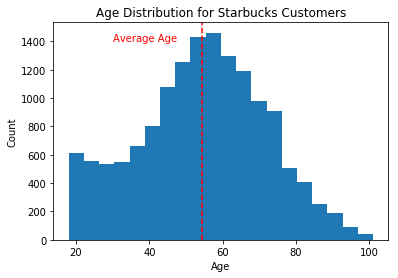

In [22]:

# exclude age = 118  from the original dataset to show the  Age Distribution.  
dx =profile[profile['age'] != 118]

# histogram for the age distrubution of the customers .
plt.hist(dx ['age'], bins = 20);
plt.axvline(dx['age'].mean(),color='r', linestyle= '--')
plt.text(30,1400,'Average Age', color = 'red', fontsize=10)
plt.xlabel('Age');
plt.ylabel('Count');
plt.title('Age Distribution for Starbucks Customers');

In [23]:
print('The average age for Starbucks Customers {}'.format('{:0.1f}'.format(dx['age'].mean())))

The average age for Starbucks Customers 54.4


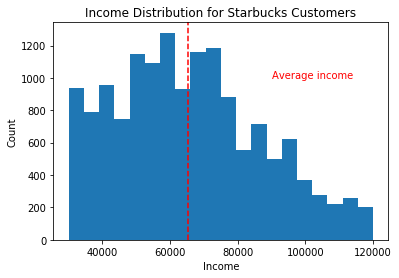

In [24]:
# histogram income distrubution for the customers .

plt.hist(dx['income'], bins = 20 );
plt.axvline(dx['income'].mean(),color='r', linestyle= '--')
plt.text(90000,1000,'Average income', color = 'red', fontsize=10)
plt.xlabel('Income');
plt.ylabel('Count');
plt.title('Income Distribution for Starbucks Customers');


In [25]:
print('The average income for Starbucks Customers {}'.format('{:0.1f}'.format(dx['income'].mean())))

The average income for Starbucks Customers 65405.0


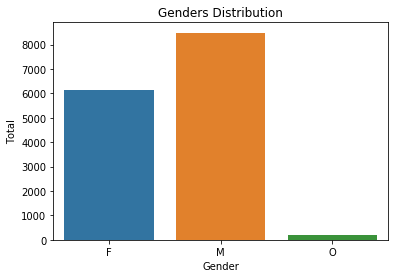

In [26]:
# plot Genders Distribution over dataset .

sb.countplot(cleaned_profile['gender'])
plt.title('Genders Distribution')
plt.ylabel('Total')
plt.xlabel('Gender')
plt.xticks(rotation = 0)
plt.show();

In [27]:
total = cleaned_profile.shape[0]
m_total = cleaned_profile[cleaned_profile['gender']== 'M'].shape[0]
f_total = cleaned_profile[cleaned_profile['gender']== 'F'].shape[0]
o_total = cleaned_profile[cleaned_profile['gender']== 'O'].shape[0]
print('The percentage of total males of Starbucks Customers {}'.format('{:0.1f}%'.format(100*m_total/total)))
print('The percentage of total females of Starbucks Customers {}'.format('{:0.1f}%'.format(100*f_total/total)))
print('The percentage of total others of Starbucks Customers {}'.format('{:0.1f}%'.format(100*o_total/total)))

The percentage of total males of Starbucks Customers 57.2%
The percentage of total females of Starbucks Customers 41.3%
The percentage of total others of Starbucks Customers 1.4%


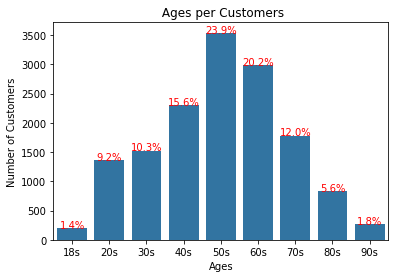

In [28]:

# plot age group .

base_color = sb.color_palette()[0]
sb.countplot(data = cleaned_profile, x = 'age_group', color= base_color ) ;
plt.xlabel('Ages');
plt.title(' Ages per Customers');
plt.ylabel('Number of Customers');

# add annotations to show percentages for each age group .
n_cus = cleaned_profile.shape[0]
cus_counts = cleaned_profile['age_group'].value_counts()
locs, labels = plt.xticks() # get the current tick locations and labels

# loop through each pair of locations and labels
for loc, label in zip(locs, labels):

# get the text property for the label to get the correct count
     count = cus_counts[label.get_text()]
     pct_string = '{:0.1f}%'.format(100*count/n_cus);

# print the annotation just below the top of the bar
     plt.text(loc, count-0, pct_string, ha = 'center', color = 'r');

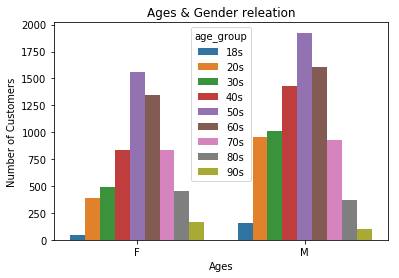

In [29]:
# exclude gender = 'O'  from the cleaned dataset to show the  Age Distribution .

dfx = cleaned_profile[cleaned_profile['gender']!='O']


# display Bar chart for two varibles (age & gender).

sb.countplot(data = dfx, x ='gender' , hue = 'age_group');

plt.xlabel('Ages');
plt.title('Ages & Gender releation');
plt.ylabel('Number of Customers');

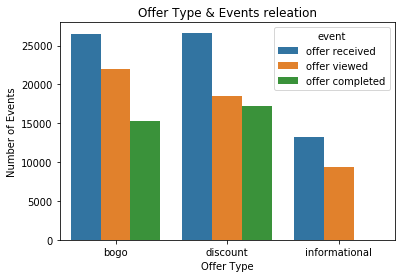

In [30]:
# plot the distrubutions of the events over offer types .

sb.countplot(data = cleaned_transcript, x ='offer_type' , hue = 'event');

plt.xlabel('Offer Type');
plt.title('Offer Type & Events releation');
plt.ylabel('Number of Events');

In [31]:
# combine 'cleaned_transcript' & 'cleaned_profile' to one Data Frame 
#to display the relation between two features  to one dataset . 
df= pd.merge(cleaned_transcript , cleaned_profile ,on ='customer_id',how='inner')
df.head()

,event,customer_id,time,offer_type,became_member_on,gender,income,age_group
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.00,bogo,2017,F,100000.0,70s
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,0.25,bogo,2017,F,100000.0,70s
2,offer completed,78afa995795e4d85b5d9ceeca43f5fef,5.50,bogo,2017,F,100000.0,70s
3,offer received,78afa995795e4d85b5d9ceeca43f5fef,7.00,informational,2017,F,100000.0,70s
4,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,9.00,informational,2017,F,100000.0,70s


In [32]:
# new Data frame for only event = 'offer completed'
df_offer_completed = df[df['event'] == 'offer completed']
df_offer_completed.head()

,event,customer_id,time,offer_type,became_member_on,gender,income,age_group
2,offer completed,78afa995795e4d85b5d9ceeca43f5fef,5.50,bogo,2017,F,100000.0,70s
8,offer completed,78afa995795e4d85b5d9ceeca43f5fef,21.25,bogo,2017,F,100000.0,70s
9,offer completed,78afa995795e4d85b5d9ceeca43f5fef,21.25,bogo,2017,F,100000.0,70s
18,offer completed,e2127556f4f64592b11af22de27a7932,21.75,bogo,2018,M,70000.0,60s
19,offer completed,e2127556f4f64592b11af22de27a7932,21.75,discount,2018,M,70000.0,60s


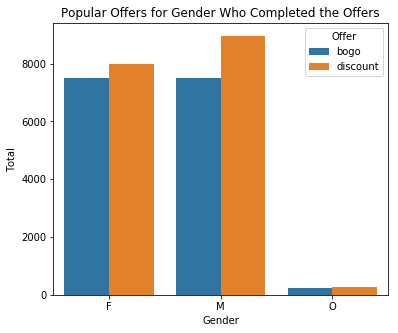

In [33]:
# plot the Popular Offers that offers are completed over gender.

plt.figure(figsize=(6, 5))
sb.countplot(x= df_offer_completed.gender, hue=df_offer_completed.offer_type)
plt.title('Popular Offers for Gender Who Completed the Offers')
plt.ylabel('Total')
plt.xlabel('Gender')
plt.xticks(rotation = 0)
plt.legend(title='Offer')
plt.show();

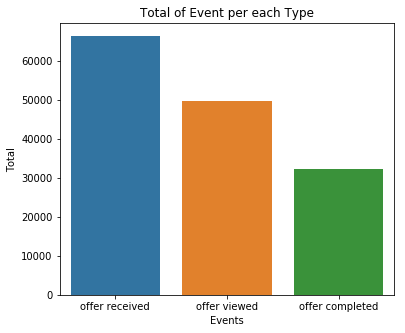

In [34]:
# polt bar for total of Events per each Type of events
plt.figure(figsize=(6, 5))
sb.countplot(x=df['event'])
plt.title('Total of Event per each Type')
plt.ylabel('Total')
plt.xlabel('Events')
plt.xticks(rotation = 0)
plt.legend(title='Offer')
plt.show();

In [35]:
of_re = sum(df['event'] == 'offer received')
of_vi = sum(df['event'] == 'offer viewed')
of_com = sum(df['event'] == 'offer completed')

print('Percentage of completed offers from the total offers recevied {}'.format('{:0.1f}%'.format(100*of_com/of_re)))
print('Percentage of completed offers  from the total viewed offers {}'.format('{:0.1f}%'.format(100*of_com/of_vi)))
print('Percentage of viewed offers  from the total offers recevied {}'.format('{:0.1f}%'.format(100*of_vi/of_re)))


Percentage of completed offers from the total offers recevied 48.8%
Percentage of completed offers  from the total viewed offers 65.1%
Percentage of viewed offers  from the total offers recevied 75.0%


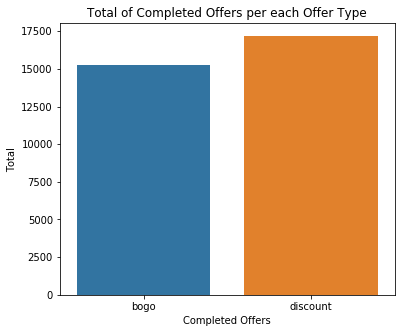

In [36]:
# polt bar for total of Events per each Type of events
plt.figure(figsize=(6, 5))
sb.countplot(x=df_offer_completed['offer_type'])
plt.title('Total of Completed Offers per each Offer Type')
plt.ylabel('Total')
plt.xlabel('Completed Offers')
plt.xticks(rotation = 0)
plt.legend(title='Offer')
plt.show();

In [37]:
total= df_offer_completed.shape[0]
                            
bogo = df_offer_completed[df_offer_completed['offer_type']== 'bogo'].shape[0]
                            
discount = df_offer_completed[df_offer_completed['offer_type']== 'discount'].shape[0]
                            
print('The percentage of total bogo offer for customers who take the offer  {}'.format('{:0.1f}%'.format(100*bogo/total)))
                            
print('The percentage of total discount offer for customers who take the offer  {}'.format('{:0.1f}%'.format(100*discount/total)))


The percentage of total bogo offer for customers who take the offer  47.0%
The percentage of total discount offer for customers who take the offer  53.0%


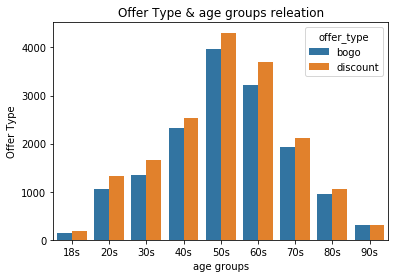

In [38]:
# plot the distrubutions of offer types over ages groups for completed offers only .

sb.countplot(data = df_offer_completed, x ='age_group' , hue = 'offer_type' );

plt.xlabel('age groups');
plt.title('Offer Type & age groups releation');
plt.ylabel('Offer Type');

## Data Modeling 

### Data preparation 

In [39]:
df.head()

,event,customer_id,time,offer_type,became_member_on,gender,income,age_group
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.00,bogo,2017,F,100000.0,70s
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,0.25,bogo,2017,F,100000.0,70s
2,offer completed,78afa995795e4d85b5d9ceeca43f5fef,5.50,bogo,2017,F,100000.0,70s
3,offer received,78afa995795e4d85b5d9ceeca43f5fef,7.00,informational,2017,F,100000.0,70s
4,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,9.00,informational,2017,F,100000.0,70s


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148805 entries, 0 to 148804
Data columns (total 8 columns):
event               148805 non-null object
customer_id         148805 non-null object
time                148805 non-null float64
offer_type          148805 non-null object
became_member_on    148805 non-null int64
gender              148805 non-null object
income              148805 non-null float64
age_group           148805 non-null category
dtypes: category(1), float64(2), int64(1), object(4)
memory usage: 14.2+ MB


In [41]:
# Check for dulicated rows in the dataset.
sum(df.duplicated(subset=None, keep='first'))

1512

In [42]:
def prepear_df(df) :

    # drop all duplicates rows.

    df_model = df.copy()
    
    df_model.drop_duplicates(inplace=True)

    #  Encode the 'gender' data to numerical values
    
    df_model['gender_code'] = df_model['gender']
    
    gen={'M':0,'F':1,'O':2}
    df_model['gender_code'].replace(gen, inplace=True)


    #  Encode the 'group_age' data to numerical values
    
    df_model['age_group_code'] = df_model['age_group']
    
    ages = {'18s':1, '20s':2, '30s':3, '40s':4, '50s':5,'60s':6, '70s':7, '80s':8, '90s':9 }

    df_model['age_group_code'].replace(ages, inplace=True)
    
    
        # Remove two columns not used after Re-Encoding
    df_model.drop(['gender', 'age_group'], axis=1, inplace=True)


    # one hot encoding to 'event' & 'offer_type' columns .
    df_model= pd.get_dummies(df_model,columns=["event", "offer_type"],prefix=None)

    


    return df_model


In [43]:
df_model = prepear_df(df)

df_model.head()



,customer_id,time,became_member_on,income,gender_code,age_group_code,event_offer completed,event_offer received,event_offer viewed,offer_type_bogo,offer_type_discount,offer_type_informational
0,78afa995795e4d85b5d9ceeca43f5fef,0.00,2017,100000.0,1,7,0,1,0,1,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,0.25,2017,100000.0,1,7,0,0,1,1,0,0
2,78afa995795e4d85b5d9ceeca43f5fef,5.50,2017,100000.0,1,7,1,0,0,1,0,0
3,78afa995795e4d85b5d9ceeca43f5fef,7.00,2017,100000.0,1,7,0,1,0,0,0,1
4,78afa995795e4d85b5d9ceeca43f5fef,9.00,2017,100000.0,1,7,0,0,1,0,0,1


In [44]:
#Check for dulicated rows in the  df_model dataset.
sum(df_model.duplicated(subset=None, keep='first'))

0

In [45]:
# Check for the balanced classes 
df_model['event_offer completed'].value_counts()

0    116361
1     30932
Name: event_offer completed, dtype: int64

### Modeling

In [46]:
# Split the data into features and target label
label = df_model['event_offer completed']
features = df_model.drop(['customer_id', 'event_offer completed'], axis = 1)


In [47]:
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score,f1_score

# Split the 'features' and 'label' data into training and testing sets

X = features
y = label

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.2, random_state=42)

In [48]:
# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))


Training set has 117834 samples.
Testing set has 29459 samples.


#### Gaussian Naive Bayes Classifiers :

In [49]:
from sklearn.naive_bayes import GaussianNB

# Define the model (with default hyperparameters)
clf = GaussianNB()

# Fit the model
clf.fit(X_train, y_train)

# Make predictions using the unoptimized and model
train_predictions = clf.predict(X_train)
test_predictions = clf.predict(X_test)

print('The Training F1 Score is',f1_score(train_predictions, y_train))
print('The Testing F1 Score is', f1_score(test_predictions, y_test))

The Training F1 Score is 0.393747770535
The Testing F1 Score is 0.395941727367


#### KNeighbors Classifier :

In [50]:
from sklearn.neighbors import KNeighborsClassifier

# Define the model (with default hyperparameters)
clf = KNeighborsClassifier()

# Fit the model
clf.fit(X_train, y_train)

# Make predictions using the unoptimized and model
train_predictions = clf.predict(X_train)
test_predictions = clf.predict(X_test)

print('The Training F1 Score is',f1_score(train_predictions, y_train))
print('The Testing F1 Score is', f1_score(test_predictions, y_test))

The Training F1 Score is 0.822623617069
The Testing F1 Score is 0.685686746988


#### AdaBoost Classifier :

In [51]:
from sklearn.ensemble import AdaBoostClassifier

# Define the model (with default hyperparameters)
clf = AdaBoostClassifier()

# Fit the model
clf.fit(X_train, y_train)

# Make predictions using the unoptimized and model
train_predictions = clf.predict(X_train)
test_predictions = clf.predict(X_test)


print('The Training F1 Score is',f1_score(train_predictions, y_train))
print('The Testing F1 Score is', f1_score(test_predictions, y_test))

The Training F1 Score is 1.0
The Testing F1 Score is 1.0


### Improving Results (Model Tuning)

In [55]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

clf = KNeighborsClassifier()

# TODO: Create the parameters list you wish to tune.

parameters = {'n_neighbors':[3,5,11,19],'weights':['uniform','distance'],
              'metric':['euclidean','manhattan']}

# TODO: Make an fbeta_score scoring object.
scorer = make_scorer(f1_score)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method.
grid_obj = GridSearchCV(clf, parameters , scoring=scorer,verbose= 1,cv=3,n_jobs= -1)

# TODO: Fit the grid search object to the training data and find the optimal parameters.
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator.
best_clf = grid_fit.best_estimator_

# Fit the new model.
best_clf.fit(X_train, y_train)

# Make predictions using the new model.
best_train_predictions = best_clf.predict(X_train)
best_test_predictions = best_clf.predict(X_test)

# Calculate the f1_score of the new model.
print('The training F1 Score is', f1_score(best_train_predictions, y_train))
print('The testing F1 Score is', f1_score(best_test_predictions, y_test))

# Let's also explore what parameters ended up being used in the new model.
best_clf

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  4.3min finished


The training F1 Score is 1.0
The testing F1 Score is 0.780592689539


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='distance')